In [1]:
%matplotlib inline

import numpy
import shapely.geometry, shapely.ops
import fiona
import collections
import descartes
import matplotlib.pyplot as plt
import scipy.spatial

In [2]:
# !rm -r ne_110m_land*
# !wget http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/physical/ne_110m_land.zip
# !unzip ne_110m_land.zip

In [3]:
shapes = []
bbox = (0, -90, 180, 90)

def get_land(bbox=None): 
    # Load up shape data from shapefile
    with fiona.drivers():
        with fiona.open('ne_110m_land.shp') as source:
            if bbox:
                source = source.filter(bbox=bbox)
            shapes = shapely.ops.cascaded_union([
                      shapely.geometry.asShape(s['geometry'])
                      for s in source])
    
    # There's a small issue with part of the polygon for North 
    # America, we'll just clip it out for now
    shapes = shapes.difference(shapely.geometry.box(-132.71, 54.04, -132.72, 54.05))
            
    # Clip if we've got something to clip
    if bbox:
        bbox_shape = shapely.geometry.box(*bbox)
        return shapes.intersection(bbox_shape)
    else:
        return shapes

In [4]:
def make_grid(bbox, npoints, graticule_spacing):
    """ Make some graticule LineStrings
    """
    longitudes = numpy.linspace(bbox[0], bbox[2], npoints)
    latitudes = numpy.linspace(bbox[1], bbox[3], npoints)
    return shapely.geometry.MultiLineString(
        [LineString(numpy.transpose([longitudes, latitude * numpy.ones(len(longitudes))]))
         for latitude in latitudes[::int(npoints / graticule_spacing)]] +
        [LineString(numpy.transpose([longitude * numpy.ones(len(latitudes)), latitudes]))
         for longitude in longitudes[::int(npoints / graticule_spacing)]])

def plot_graticules(graticules, axes=None):
    axes = axes or plt.gca()
    for graticule in graticules:
        axes.plot(*graticule.xy, 
                  dashes=(4, 2), 
                  color='gray', 
                  zorder=0)

def plot_land(land, axes=None):
    axes = axes or plt.gca()
    for shape in land:
        axes.add_patch(descartes.PolygonPatch(
                shape,
                facecolor='white', 
                edgecolor='black', 
                zorder=2))

def plot_centre(centre, axes=None):
    axes = axes or plt.gca()
    centre_fmt = dict(markeredgecolor='red', markerfacecolor='red', marker='o')
    plt.plot(*centre.xy, **centre_fmt)

def fix_axes(bbox_shape, axes=None):
    axes = axes or plt.gca()
    axes.set_axis_off()
    axes.set_aspect('equal')
    
    # Set limits from shape
    coords = numpy.asarray(bbox_shape.boundary.coords)
    xmin, ymin = coords.min(axis=0)
    xmax, ymax = coords.max(axis=0)
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(ymin, ymax)

In [5]:
from shapely.geometry import Polygon, LineString, Point

bbox = (-180, -90, 180, 90)
bbox_shape = shapely.geometry.box(*bbox)

graticules = make_grid(bbox=bbox, npoints=200, graticule_spacing=20)
centre = Point([0, 0])
land = get_land(bbox)

In [6]:
area_idx = numpy.argsort([l.area for l in land])
shapes = shapely.geometry.MultiPolygon([land[int(i)] for i in area_idx[-1:-7:-1]])

In [7]:
from numpy import sin, cos, degrees, radians, arcsin, arctan, arctan2, \
                  sqrt, newaxis, asarray

def get_coords_as_array(shape):
    """ Get the coordinates from a Shapely geometry as a 2 by N numpy array,
        where N is the number of points defining the boundary or line.
        
        Arguments:
            shape - a Shapely geometry, from shapely.geometry.*
        
        Returns: 
            points - either a 2 by N numpy array (where the geometry is a single
                shape), or a list of 2 by N numpy arrays (where the shape's
                geometry has multiple parts
        
    """
    # Proceed as if we have a Ring or LineString
    if shape.type in ('LineString', 'Point'):
        return numpy.asarray(shape.coords).transpose()
    elif shape.type is 'Polygon':
        return get_coords_as_array(shape.boundary)
    elif shape.type.startswith('Multi'):
        return [get_coords_as_array(s) for s in shape]
    else:
        raise NotImplementedError(
            "Can't do anything with geometry of type {0}".format(shape.type))

def sterographic_projection(centre, points):
    """ Transform function for points using a stereographic projection
        centred on the given centre
    """
    theta_c, phi_c = radians(centre)
    scale = 2 / (1 + sin(phi_c) * sin(phi) + cos(phi_c) * cos(phi) * cos(theta - theta_c))
    x = scale * cos(phi) * sin(theta - theta_c)
    y = scale * (cos(phi_c) * sin(phi) - sin(phi_c) * cos(phi) * cos(theta - theta_c))
    return x, y

def gnomonic_projection(centre, points):
    """ Transform points using a gnominic projection with centre point centre.
        
        All points should be given in degrees longitude and degrees latitude

        Arguments:
            centre - the centre point of the projection - this is 
                where the gnominic plane touches the surface of the 
                earth. Given as a tuple of longitude and latitude in degrees
        
        Returns:
            a function to transform a point into the projective plane
    """
    theta_c, phi_c = radians(centre)
    theta, phi = radians(points)
    scale = 1 / (sin(phi_c) * sin(phi) + cos(phi_c) * cos(phi) * cos(theta - theta_c))
    x = scale * cos(phi) * sin(theta - theta_c)
    y = scale * (cos(phi_c) * sin(phi) - sin(phi_c) * cos(phi) * cos(theta - theta_c))
    return numpy.vstack([x, y])

def inverse_gnomonic_projection(centre):
    """ Transform points from the gnomonic plane with centre point centre
    """
    θc, ϕc = radians(centre)
    def _transform_fn(x, y):
        ρ = numpy.sqrt(x ** 2 + y ** 2)
        α = numpy.arctan(ρ)
        θ = θc + numpy.arctan2(x * sin(α),
                               ρ * cos(ϕc) * cos(α) - y * sin(ϕc) * sin(α))
        ϕ = numpy.arcsin(cos(α) * sin(ϕc) + (y + sin(α) * cos(ϕc)) / ρ)
        return θ, ϕ
    return _transform_fn

In [8]:
import pymaxion
from pymaxion.rotations import rotation_matrix
from pymaxion.conversions import cartesian_to_spherical, spherical_to_cartesian

from mpl_toolkits.mplot3d import Axes3D

In [9]:
a = numpy.radians(45)
rot1 = pymaxion.rotations.rotation_matrix([a, 0, 0])
rot2 = pymaxion.rotations.rotation_matrix([0, 0, a])
assert(numpy.allclose(numpy.dot(rot1, rot2), pymaxion.rotations.rotation_matrix([a, 0, a])))

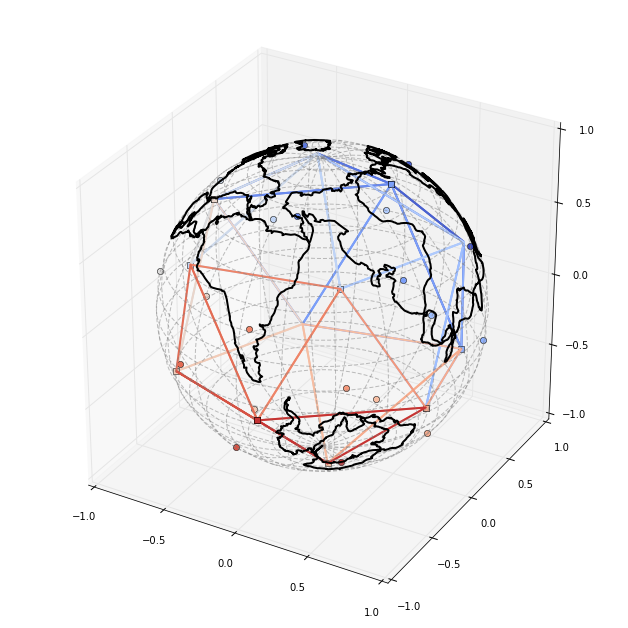

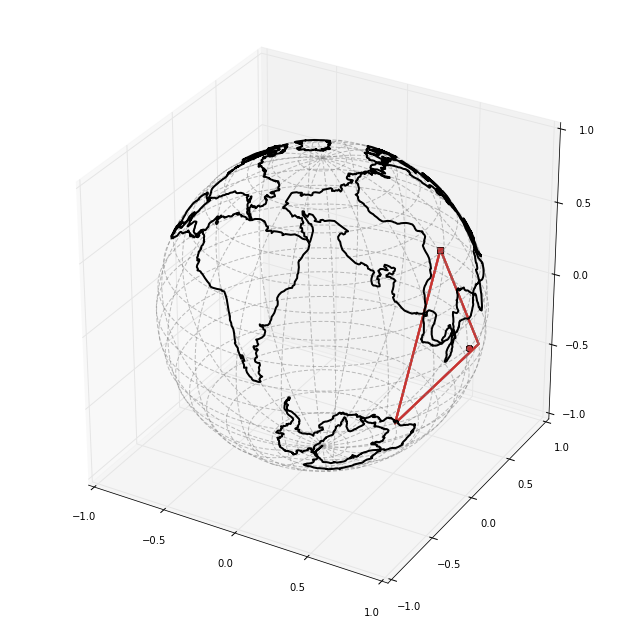

In [27]:
import itertools

fig1 = plt.figure(figsize=(11,11))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.set_zlim(-1, 1)
fig2 = plt.figure(figsize=(11,11))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.set_zlim(-1, 1)

proj = pymaxion.DymaxionProjection()
nfaces = len(proj.faces)
cmap = plt.get_cmap('coolwarm')
final_faces = []
for face_idx in range(nfaces):
    color = cmap(face_idx / nfaces)
    rotation = proj.face_rotation_matrices[face_idx]
    transform = lambda pt: numpy.dot(rotation, pt)

    # Now we can plot these up
    vertex = proj.vertices[proj.faces[face_idx][0]] 
    center = proj.face_centres[face_idx]
    face_points = proj.vertices[proj.faces[face_idx]]
    face_points = numpy.vstack([face_points, face_points[0]]).transpose()
    ax1.plot(*center[numpy.newaxis].transpose(), color=color, marker='o')
    ax1.plot(*face_points, color=color, linewidth=2)
    ax1.plot(*vertex[numpy.newaxis].transpose(), color=color, marker='s')
    center = transform(center)
    vertex = transform(vertex)
    face_points = transform(face_points)
    ax2.plot(*center[numpy.newaxis].transpose(), color=color, marker='o')
    ax2.plot(*face_points, color=color, linewidth=2)
    ax2.plot(*vertex[numpy.newaxis].transpose(), color=color, marker='s')
    final_faces.append(face_points)

# Check that we have all our values in the right place
for a, b in itertools.combinations(final_faces, 2):
    assert(numpy.allclose(a, b) 
       or numpy.allclose(a, b[:, (0, 2, 1, 3)]))
    
gfmt = dict(color='gray', dashes=(4, 2), alpha=0.5)
sfmt = dict(color='black', linewidth=2)
for collection, fmt in [(graticules, gfmt), (shapes.boundary, sfmt)]:
    for line in collection:
        points = numpy.radians(line.coords).transpose()
        points = spherical_to_cartesian(*points)
        ax1.plot(*points, **fmt)
        ax2.plot(*points, **fmt)
fig1.savefig('initial_faces.png')
fig2.savefig('final_faces_after_rotation.png')

In [ ]:
face_idx = 5
transform = lambda pts: \
    numpy.dot(proj.face_rotation_matrices[face_idx], pts)

fig1 = plt.figure(figsize=(11,11))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.set_zlim(-1, 1)

# formats
gfmt = dict(color='gray', dashes=(4, 2), alpha=0.5)
lfmt = dict(color='gray', linewidth=2)
ffmt = dict(color='red', linewidth=2)

# Plot face location
face_points = proj.vertices[proj.faces[face_idx]]
face_points = numpy.vstack([face_points, face_points[0]]).transpose()
face_points = transform(face_points)
ax1.plot(*face_points, **ffmt)

# Make plots
for collection, fmt in ((graticules, gfmt), (shapes.boundary, lfmt)):
    for geom in collection:
        points = numpy.radians(geom.coords).transpose()
        points = spherical_to_cartesian(*points)
        points = transform(points)
        ax1.plot(*points, **fmt)

In [ ]:
bbox = (-45, -30, 45, 90)
centre = [0, 0]

from pymaxion.projections import gnomonic_projection, sterographic_projection
gnom = gnomonic_projection(*centre, longlat=True)
stereo = sterographic_projection(*centre, longlat=True)
ident = lambda *x: x

def make_map(bbox, centre=None, transform=None, xlim=None, ylim=None):
    # Deal with arguments
    transform = transform or ident
    if centre is None:
        centre = (0, 0)
    bbox_shape = shapely.geometry.box(*bbox)

    # Make some graticules, get land info, make centre
    graticules = make_grid(bbox=bbox, npoints=200, graticule_spacing=20)
    land = get_land(bbox)
    centre = shapely.geometry.Point(centre)

    # Generate map
    fig = plt.figure(figsize=(11, 11))
    axes = fig.gca()
    plot_graticules(shapely.ops.transform(transform, graticules))
    plot_land(shapely.ops.transform(transform, land))
    plot_centre(shapely.ops.transform(transform, shapely.geometry.Point(centre)))
    fix_axes(bbox_shape)
    if xlim:
        axes.set_xlim(*xlim)
    if ylim:
        axes.set_ylim(*ylim)

make_map(bbox, centre=centre)
make_map(bbox, centre=centre, transform=gnom, xlim=(-1, 1), ylim=(-1, 1))
make_map(bbox, centre=centre, transform=stereo, xlim=(-1, 1), ylim=(-1, 1))

In [ ]:
import pymaxion

In [ ]:
from pymaxion.conversions import cartesian_to_spherical
import itertools
import descartes

fig = plt.figure(figsize=(11, 11))
bbox = (-180, -90, 180, 90)
make_map(bbox, transform=stereo, centre=None)
bbox_shape = shapely.geometry.box(*bbox)
axes = plt.gca()
cmap = plt.get_cmap('coolwarm')

for idx, poly in enumerate(proj.latlong_faces):    
    # Plot the polygon
    poly = shapely.ops.transform(stereo, poly).intersection(bbox_shape)
    color = cmap(idx / len(proj.faces))
    axes.add_patch(descartes.PolygonPatch(poly, facecolor=color, edgecolor=color, alpha=0.3, zorder=10))
    
    # Plot centre point
    centre = shapely.geometry.Point(
        numpy.degrees(cartesian_to_spherical(*proj.face_centres[idx])))
    centre = shapely.ops.transform(stereo, centre)
    x, y = numpy.asarray(centre.coords).ravel()
    axes.plot(x, y, marker='o', color=color)
    axes.text(x, y, s='Index {0}'.format(idx))
axes.set_xlim(-5, 5)
axes.set_ylim(-3, 3)

In [ ]:
face_idx = 0

In [ ]:
def remap(longitude, latitude):
    """ Maps latitudes and longitudes onto the correct values
    """
    longitude, latitude = numpy.asarray(longitude), numpy.asarray(latitude)
    longitude[longitude > 180] -= 360
    longitude[longitude < -180] += 360
    latitude[latitude > 90] -= 180
    latitude[latitude < -90] += 180
    return longitude, latitude

def translate(dx, dy):
    """ Returns a transformation which translates the 
        map through a given change in longitude and latitude.
    """
    dx, dy = remap(dx, dy)
    def _transform(x, y):
        return remap(x + dx, y + dy)
    return _transform

In [ ]:
land = get_land()
gnom = gnomonic_projection([0, 0])
bounds = shapely.geometry.box(-45, -45, 45, 45)
centres = [numpy.degrees(cartesian_to_spherical(c)).ravel()
           for c in proj.face_centres]
print(centres)
for centre in centres:
    try:
        print(centre)
        land_tr = shapely.ops.transform(translate(*centre), land)
        land_tr = bounds.intersection(land_tr)
        land_tr = shapely.ops.transform(gnom, land_tr)
        plt.figure()
        plot_land(land_tr)
    except shapely.topology.TopologicalError:
        pass

In [ ]:
points = numpy.array([[-90, 0, 5, 10, 45, 90, 180, 270],
                     [-45, 0, 35, -45, 41, -25, -30, 80]])

def remap(longitude, latitude):
    """ Maps latitudes and longitudes onto the correct values
    """
    longitude, latitude = numpy.asarray(longitude), numpy.asarray(latitude)
    longitude[longitude > 180] -= 360
    longitude[longitude < -180] += 360
    latitude[latitude > 90] -= 180
    latitude[latitude < -90] += 180
    return longitude, latitude

def translate(dx, dy):
    """ Returns a transformation which translates the 
        map through a given change in longitude and latitude.
    """
    dx, dy = remap(dx, dy)
    def _transform(x, y):
        return remap(x + dx, y + dy)
    return _transform

In [ ]:
shapely.ops.transform(translate(32, 90), land)

In [ ]:
faces = construct_face_polygons()
land_segments = []
for idx, face in enumerate(faces):
    try:
        land_segments.append(land.intersection(face))
    except shapely.topology.TopologicalError:
        try:
            # We need to rotate to try doing things again, so rotate data
            # to the centre of the face
            cx, cy = numpy.degrees(cartesian_to_spherical(proj.face_centres[idx])).ravel()
            forwards = translate(-cx, -cy)
            backwards = translate(cx, cy)
            land_tr = shapely.ops.transform(forwards, land)
            face_tr = shapely.ops.transform(forwards, face)
            intersection = face_tr.intersection(land_tr)
            land_segments.append(
                shapely.ops.transform(backwards, 
                                      intersection))
        except shapely.topology.TopologicalError:
            pass
        


In [ ]:
make_map(bbox)
axes = plt.gca()
cmap = plt.get_cmap('coolwarm')
for idx, multipoly in enumerate(land_segments):    
    # Plot the polygon
    color = cmap(idx / len(proj.faces))
    for poly in multipoly:
        axes.add_patch(descartes.PolygonPatch(
                poly, facecolor=color, edgecolor=color, 
                alpha=0.9, zorder=3))